# Introduction

In this assignment, we have been given a rectangular tank filled with a fluid and we have to analyze the various electrical properties of this system.

# Tasks

## Part - 1

The given rectangular tank can be modeled as a parallel plate capacitor having a dielectric slab inserted to it. For a parallel plate capacitor, it's capacitance is given by the following formula,
$$ C=\frac{\epsilon_0 A}{L_y-h(1-\frac{1}{\epsilon_r})} $$
Then, for a RLC circuit, $\omega_0=\frac{1}{\sqrt{LC}}$

Hence, if $\omega_0$,L,A are known, then $h$ can be calculated from them.

### Code

In [1]:
#Importing required functions and libraries
from pylab import *
import math
import mpl_toolkits.mplot3d.axes3d as p3

#Calculating 'h', if required parameters are given
#Values are taken at SI units
#L->Inductance connected to circuit, A->Area of cross-section of plate
#w->Resonant frequency, Er->Dielectric constant
def calculate_h(Er,L,A,w,Ly):
    Eo = 8.85*(10**(-12))
    h = (((L*w*w*A*(Eo)) - Ly)*Er)/(1-Er)
    return h
print('Value of h for a given set of initial parameters :',calculate_h(2,0.015,1,10**6,0.2)*100,'cms')

Value of h for a given set of initial parameters : 13.450000000000006 cms


## Part - 2

We can parallelize computation by using vectorization of arrays, this is faster than using loops to assign or change values of a matrix. We can use vectorised codes using $numpy$ arrays. They parallelize the computation process as opposed to taking and changing a single variable at a time. In a vectorized code, values for a row updated at a time instead of updating single values at a time. Hence, this makes the code more faster and compact, thus making it more readable.

As the boundary case has to be handled separately, we can split the matrix into 3 parts using slicing, one m<k,one m=k and another m>k. Then, we can update these 3 parts of matrix separately.

## Part - 3

### Solving for potential
In this part we have to write a function to solve for potential matrix using $Laplace$ equation.
Let the tank be split into $N\times M$ grids, and let $\phi$ be the potential matrix.
Then the $Laplace$ equation is given as follows,

$ \phi_{m,n} = \frac{\phi_{m-1,n}+\phi_{m+1,n}+\phi_{m,n-1}+\phi_{m,n+1}}{4} , m \neq k  $

$ \phi_{m,n} = \frac{\epsilon_r \phi_{m-1,n}+\phi_{m+1,n}}{1+\epsilon_r} , m=k $

This functions takes in several parameters and then solves and returns the final potential matrix after desired accuracy is reached. Here, top plate is always at +1V and the side and bottom plates are grounded (0v).

### Modeling Error

Error varies exponentially with the number of iterations. The equation for the error is given as,

$error = y = A e^{Bx}$

where $A$ and $B$ are constants and $x$ is the number of iterations.

Stopping condition is when,
$ \int_{N+0.5}^{\infty} A e^{k} dk < \delta $

The integration evaluates to $ - \frac{A}{B} e^{B(N+0.5)} $

Hence, $N$ is the required number of iterations taken to reach desired accuracy when the following condition holds,
$ - \frac{A}{B} e^{B(N+0.5)} < \delta $

### Code

No. of iterations to reach the desired accuracy : 15329


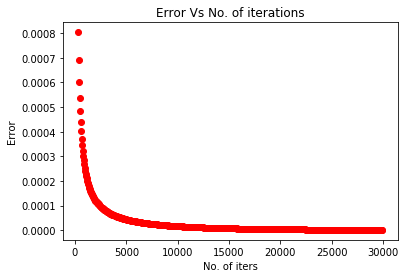

In [2]:
#function to find the values of A and B using the error vector
def fitForError(errors, x):
    A = zeros((len(errors), 2))
    A[:, 0] = 1
    A[:, 1] = x
    return A, lstsq(A, log(errors), rcond=None)[0]

#Function to solve the Laplace equation taking the specified params
def solve_laplace(M,N,delta1,k,delta2,No,Er):
    Nx = M                      #size along x
    Ny = N                      #size along y
    Niter = No                  #No. of max iters
    phi = np.zeros((Ny,Nx))     #Defining potential matrix
    err = zeros(Niter)          #Defing array to record errors 
    itr_taken = Niter
    phi[0,:] = 1                #Giving +1v at the top
    for j in range(Niter):      #Calculating the potential values until convergence
        oldphi = phi.copy()
        
        phi[1:k, 1:-1] = 0.25*(phi[1:k, 0:-2]+phi[1:k, 2:]+phi[0:k-1, 1:-1]+phi[2:k+1, 1:-1])
        phi[k,1:-1] = (1/(1+Er))*( phi[k-1,1:-1] + Er*phi[k+1,1:-1] )
        phi[k+1:-1, 1:-1] = 0.25*(phi[k+1:-1, 0:-2]+phi[k+1:-1, 2:]+phi[k:-2, 1:-1]+phi[k+2:, 1:-1])
        
        err[j] = (abs(phi-oldphi)).max()
        
        
    M2, c2 = fitForError(err[500:], range(Niter)[500:]) # fit - taking iterations > 500
    A = (exp(c2[0]))
    B = c2[1]
    for j in range(500,Niter):
        er = (A*((exp(B*(j+0.5)))))/(-B)
        if(er<delta2):
            itr_taken=j+1
            break
            
    return phi,itr_taken,err

#Checking the working of the solve_laplace function by plotting it's output for a set of parameters
Ny = 400
Nx = 200
delta1 = 20/Ny
itr = 30000
k = 160
delta2 = (5.7)*(10**(-2))
Er = 2
phi,itr_taken,err = solve_laplace(Nx,Ny,delta1,k,delta2,itr,Er)
print("No. of iterations to reach the desired accuracy :",itr_taken)
#Plotting Error Vs No. of iterations
#We can observe error value converges
f = figure()
ax = f.add_subplot(111)
ax.plot(range(itr)[300::50], err[300::50], 'or')
title('Error Vs No. of iterations')
xlabel('No. of iters')
ylabel('Error')
show()

Contour Plot of the potential function in the tank after steady state is reached.

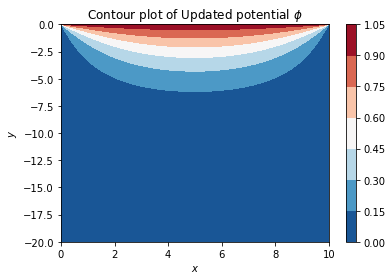

In [3]:
#Contour plot of potential of the tank for the above specified parameters
y = linspace(0, 20, Ny)  # range of y
x = linspace(0, 10, Nx)  # range of x
X, Y = meshgrid(x, -y)
fig = figure()
ax = fig.add_subplot(111)
plt1 = ax.contourf(X, Y, phi, cmap="RdBu_r")
title("Contour plot of Updated potential $\phi$")
xlabel("$x$")
ylabel("$y$")
ax = gca()
fig.colorbar(plt1, ax=ax, orientation='vertical')
show()

## Part - 4

Here, we have to find charges at the boundaries of the plate. $Q_{top}$ is charge present at the top plate, and $Q_{fluid}$ is the charge present in the walls of the tank which are in contact with the fluid.

We can calculate the charges using boundary conditions derived from Gauss Law.
$$ \nabla E = \frac{\rho}{\epsilon} $$
where E-> Electric field, $\rho$->charge density.

Just outside the fluid there is no electric field, and the electric field just inside the fluid can be calculated using the potential matrix( $ - \frac{d \phi}{dr} = E $ ).
As $\epsilon$ is a constant, Charge on the plates is directly propotional to the difference of electric fields just outside and inside of the plate.
$$ \frac{q}{z} = \epsilon EA $$
Hence, charge per unit length is propotional to the sum of electric fields of each grid present in the boundary

### Code

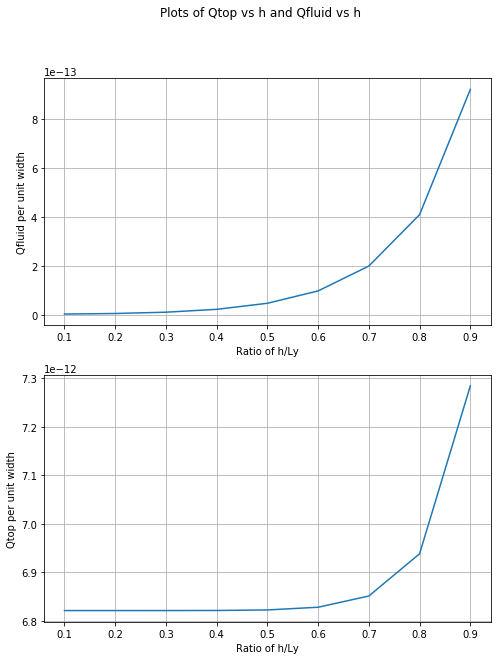

In [4]:
#Function to calculate chanrges on top plate and the side walls containg the fuid for a set of params
def cal_charge(Ny,Nx,delta1,itr,k,delta2,Er):
    
    #Finding the potential distribution for the given set of params
    phi,itr_taken,err = solve_laplace(Nx,Ny,delta1,k,delta2,itr,Er)
    
    #Distance between 2 cells
    delx = 10/Nx
    dely = 20/Ny
    Area = delx*dely
    eps = 8.85*(10**(-12))
    #Summing up the electric field in the walls and bottom
    Q_fluid = 0
    E_nor1 = sum(phi[k+1:Ny,1])/delx
    E_nor2 = sum(phi[k+1:Ny,-2])/(delx)
    E_nor3 = sum(phi[Ny-2,1:Nx-1])/dely
    Q_fluid = (E_nor1 + E_nor2 + E_nor3)*(eps*Area)
    
    #summing up the electric field at the top
    Q_top = 0
    E_nor = sum(phi[0]-phi[1])/(dely)
    Q_top = E_nor*(eps*Area)
        
    return Q_fluid,Q_top

#Function to plot charge Vs h
def plot_charge():
    Qf,Qt = [], []
    
    #Calculating charge for different heights of liquid
    for i in range(1,10):
        ratio = i/10
        q1,q2 = cal_charge(200,100,20/Ny,10000,int(200-(ratio)*(200)),10**(-6),2)
        Qf.append(q1)
        Qt.append(q2)
        
    #Plotting Qtop, Qfluid Vs h (height of the fluid)
    f = figure(figsize=(8,10))
    ax = f.add_subplot(211)
    ax2 = f.add_subplot(212)
    x = [i/10 for i in range(1,10)]
    ax.plot(x,Qf)
    ax2.plot(x,Qt)
    f.suptitle("Plots of Qtop vs h and Qfluid vs h")
    ax.set_xlabel('Ratio of h/Ly')
    ax.set_ylabel('Qfluid per unit width')
    ax.grid(True)
    ax2.set_xlabel('Ratio of h/Ly')
    ax2.set_ylabel('Qtop per unit width')
    ax2.grid(True)
    show()
    
plot_charge()

### Inference

From the above plots, we can see that charge doesn't vary linearily with h. Charge on a capacitor is given by, $ Q = CV $. Hence, for a given voltage, charge is directly propotional to capacitance.

And capcitance is given by, $C=\frac{\epsilon_0 A}{L_y-h(1-\frac{1}{\epsilon_r})}$

We can see that capacitance varies proportionately with $\frac{1}{1-\frac{h}{2}}$, hence charge varies proportionately with $\frac{1}{1-\frac{h}{2}}$. This is the equation of a hyperbola.

The above graphs are hyperbolic in nature. Hence, our result is correct.

## Part - 5

For $\frac{h}{L_y}=0.5$, we have to find the electric field and verify the continuity of $D$ (electric displacement field).

We can find the electric field at the centre by using the potential function.
$$ - \frac{d \phi}{dr} = E $$

And Electric displacement field is given by,
$$ D = \epsilon E $$
$$ D = \epsilon_r \epsilon_0 E $$

### Code

In [5]:
#Function to calculate field at the central point
def calc_field(Ny,Nx,delta1,itr,k,delta2,Er):
    
    #Calculating potential distribution
    phi,itr_taken,err = solve_laplace(Nx,Ny,delta1,k,delta2,itr,Er)
    
    delx = 10/Nx
    dely = 20/Ny
    
    #Calculating tangential and normal components of electric field in both medium
    Ey_air = (phi[k-1,Nx//2] - phi[k,Nx//2])/(dely)
    Ex_air = (phi[k,Nx//2] - phi[k,Nx//2 +1])/(delx)
    Ey_fluid = (phi[k,Nx//2] - phi[k+1,Nx//2])/(dely)
    Ex_fluid = (phi[k,Nx//2] - phi[k,Nx//2 +1])/(delx)
    
    print('Field at the centre')
    print('Normal Component of Electrin Field in \'air\' medium :',Ey_air,'V/cm')
    print('Normal Component of Electrin Field in \'Fluid\' medium :',Ey_fluid,'V/cm')
    print('Tangential Component of Electrin Field in \'air\' medium :',Ex_air,'V/cm')
    print('Tangential Component of Electrin Field in \'Fluid\' medium :',Ex_fluid,'V/cm')
    print()
    print('D in air :',Ey_air)
    print('D in Fluid :',Er*Ey_fluid)
    print()
    print('Ratio of fields (Ey_fluid/Ey_air) across the boundary')
    #Calculating field across the boundary
    Ey_a = (phi[k-1,1:-1] - phi[k,1:-1])/(dely)
    Ey_f = (phi[k,1:-1] - phi[k+1,1:-1])/(dely)
    print(Ey_f/Ey_a)
    
calc_field(200,100,20/Ny,18000,100,10**(-5),2)

Field at the centre
Normal Component of Electrin Field in 'air' medium : 0.022546899734665823 V/cm
Normal Component of Electrin Field in 'Fluid' medium : 0.01127227679895794 V/cm
Tangential Component of Electrin Field in 'air' medium : 0.00035714509668258176 V/cm
Tangential Component of Electrin Field in 'Fluid' medium : 0.00035714509668258176 V/cm

D in air : 0.022546899734665823
D in Fluid : 0.02254455359791588

Ratio of fields (Ey_fluid/Ey_air) across the boundary
[0.49994834 0.49994834 0.49994833 0.49994833 0.49994833 0.49994832
 0.49994832 0.49994831 0.49994831 0.4999483  0.49994829 0.49994829
 0.49994828 0.49994827 0.49994826 0.49994825 0.49994824 0.49994823
 0.49994822 0.49994821 0.4999482  0.49994819 0.49994817 0.49994816
 0.49994815 0.49994814 0.49994813 0.49994812 0.49994811 0.49994809
 0.49994808 0.49994807 0.49994806 0.49994805 0.49994804 0.49994804
 0.49994803 0.49994802 0.49994801 0.499948   0.499948   0.49994799
 0.49994799 0.49994798 0.49994798 0.49994798 0.49994797 0.4

### Inference

We can observe that ratio of electric fields across the boundary is constant (~0.5), which is equal to the inverse ratio of the dielectric constants.So, Electric displacement field is same in both the medium across all the grids in the boundary. Hence, $D$ is continuous at the air-fluid boundary.

## Part - 6

In this part, we have to verify if the field follows snell's law or not. Snell's law is given by,
$$ \frac{sin(i)}{sin(r)} = \frac{n_2}{n_1} $$
where $n_i$ is the refractive indices of respective mediums.

Refractive index is ratio of speed of light in vaccum with speed of light in that medium and hence is given by,
$$ n=\frac{1}{\sqrt{\mu_r \epsilon_r}} $$
Assuming permeability to be same for both the mediums, we can say that,
$$ \frac{n_2}{n_1}=\frac{1}{\sqrt{\epsilon_r}} $$

### Code

In [6]:
#Function to verify snell's law
def verify_snell(Ny,Nx,delta1,itr,k,delta2,Er):
    
    phi,itr_taken,err = solve_laplace(Nx,Ny,delta1,k,delta2,itr,Er)
    
    delx = 10/Nx
    dely = 20/Ny
    
    #Calculating field at central point
    Ey_air = (phi[k-1,Nx//2] - phi[k,Nx//2])/(dely)
    Ex_air = (phi[k,Nx//2] - phi[k,Nx//2 +1])/(delx)
    Ey_fluid = (phi[k,Nx//2] - phi[k+1,Nx//2])/(dely)
    Ex_fluid = (phi[k,Nx//2] - phi[k,Nx//2 +1])/(delx)
    
    #Finding angle of incidence,refraction using tangential and normal components of field
    o1 = math.degrees(math.atan( 1/(Ey_air/Ex_air) ))
    o2 = math.degrees(math.atan( 1/(Ey_fluid/Ex_fluid) ))
    
    print('Angle of incidence (observed from air to fluid) :',o1,'deg')
    print('Angle of Refraction (observed from air to fluid) :',o2,'deg')
    
    #Calculating ratio of sine of angles
    u1 = math.sin(math.radians(o1))
    u2 = math.sin(math.radians(o2))
    
    #Ratio of refractive indices is propotional to sqrt(Er)
    print('sin(i)/sin(r) =',u1/u2)
    print('Ratio of Refractive indexes =',1/sqrt(Er))
    
verify_snell(200,100,20/Ny,18000,100,10**(-5),2)

Angle of incidence (observed from air to fluid) : 0.90749485612962 deg
Angle of Refraction (observed from air to fluid) : 1.8147233263584246 deg
sin(i)/sin(r) = 0.5001361036284798
Ratio of Refractive indexes = 0.7071067811865475


### Inference

We can see that the electric field is not following the snell's law. Snell's law is valid only for propagating EM waves. Here, the potential function reaches a steady state and doesn't change after that. Hence, electric field is constant with respect to time as ($\frac{d \phi}{dt}=0$). So, this electric field doesn't propagate and hence its not neccessary to follow the snell's law.

# Conclusion

We have successfully analyzed various electrical properties like capacitance, resonant frequecy, amount of charge appeared on plates of the system. We have also verified the boundary conditions derived from the Maxwell's equation (verification of continuity of D at the boundary).